# Linear Regression  on a Combined Cycle Power Plant (CCPP) data
## Dataset description

The dataset contains 5281 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE)  of the plant.

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum has effect on the Steam Turbine, the other three of the ambient variables effect the GT performance.

In [1]:
# to get in-line plots
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd

## Import Data
Load the data from a .csv file and print data column names.

In [2]:
# Load the data

IDnumber = 1234     #set the seed
np.random.seed(IDnumber)

filename = "ccpp_Data_clean2019.csv"

df = pd.read_csv(filename,sep=";")
df_1 = pd.read_csv(filename,sep=";")


col_names = df.columns
print(col_names)

data = df.values

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')


# A quick overview of data

To inspect the data you can use the method describe()

In [3]:
data_description = stats.describe(data)
print(data_description)

data.shape

#for more interesting visualization: use pandas!

DescribeResult(nobs=5281, minmax=(array([  1.81,  25.36, 992.89,  25.56, 420.26]), array([  37.11,   81.56, 1033.29,  100.16,  495.23])), mean=array([  19.67317553,   54.31940163, 1013.22432115,   73.38815187,
        454.31701004]), variance=array([ 56.0327041 , 161.7733201 ,  35.2083789 , 217.43618617,
       291.84459771]), skewness=array([-0.13713412,  0.19522075,  0.24934713, -0.43467097,  0.29846615]), kurtosis=array([-1.04662553, -1.45165813,  0.01128758, -0.43044229, -1.05785395]))


(5281, 5)

# Split data in training, validation and test sets



Given $m$ total data, keep $m_t$ data as training data, $m_{val}:=m_{tv}-m_t$ as validation data and $m_{test}:=m - m_{val} - m_t = m-m_{tv}$ for test data. For instance one can take $m_t=m/3$ of the data as training, $m_{val}=m/3$  validation and $m_{test}=m/3$ as testing. Let us define as define

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{val}$ the validation data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

TRAINING DATA: The training data are used to compute the training loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $h$ in a given model class ${\cal H}$.
i.e. 
$$
\hat h = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

VALIDATION DATA: Validation data are used when different model classes are present (e.g. of different complexity such as linear regression which used a different number $d_j$ of features $x_1$,...$x_{d_j}$ in the model). In general, with more features one can better fit the training set, so one has to choose which one is the "best" complexity. Let ${\cal H}_{d_j}$ be the space of models as a function of the complexity $d_j$ and let 
$$
\hat h_{d_j} = {\rm arg\; min}_{h \in {\cal H}_{d_j}} \, L_S(h)
$$

One can estimate the generalization error for model $\hat h_{d_j}$ as follows:
$$
L_{{\cal D}}(\hat h_{d_j}) \simeq \frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$
and then choose the complexity which achieves the best estimate of the generalization error
$$
\hat d: = {\rm arg\; min}_{d_j} \,\frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$

TESTING DATA: Last, the test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$

In [4]:
#get number of total samples
num_total_samples = data.shape[0]

print("Total number of samples: "+str(num_total_samples))

#size of each chunk of data for training, validation, testing
size_chunk = int(num_total_samples//3)

print("Size of each chunk of data: "+str(size_chunk))

#shuffle the data
np.random.shuffle(data)

#training data

X_training = data[0:size_chunk, 0:4]
Y_training = data[0:size_chunk, 4:5]
print("Training data input size: "+str(X_training.shape))
print("Training data output size: "+str(Y_training.shape))

#validation data, to be used to choose among different models
X_validation = data[size_chunk:2*size_chunk, 0:4]
Y_validation = data[size_chunk:2*size_chunk, 4:5]
print("Validation data input size: "+str(X_validation.shape))
print("Validation data ouput size: "+str(Y_validation.shape))

#test data, to be used to estimate the true loss of the final model(s)
X_test = data[2*size_chunk:, 0:4]
Y_test = data[2*size_chunk:, 4:5]
print("Test data input size: "+str(X_test.shape))
print("Test data output size: "+str(Y_test.shape))

Total number of samples: 5281
Size of each chunk of data: 1760
Training data input size: (1760, 4)
Training data output size: (1760, 1)
Validation data input size: (1760, 4)
Validation data ouput size: (1760, 1)
Test data input size: (1761, 4)
Test data output size: (1761, 1)


# Data Normalization

It is common practice in Statistics and Machine Learning to scale the data (= each variable) so that it is centered (zero mean) and has standard deviation equal to $1$. This helps in terms of numerical stability (conditioning) of the (inverse) problems of estimating the ERM model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients. 

In [5]:
# standardize the input matrix
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_training)
X_training = scaler.transform(X_training)
print("Mean of the training input data:"+str(X_training.mean(axis=0)))
print("Std of the training input data:"+str(X_training.std(axis=0)))
X_validation = scaler.transform(X_validation) # use the same transformation on validation data
print("Mean of the validation input data:"+str(X_validation.mean(axis=0)))
print("Std of the validation input data:"+str(X_validation.std(axis=0)))
X_test = scaler.transform(X_test) # use the same transformation on test data
print("Mean of the test input data:"+str(X_test.mean(axis=0)))
print("Std of the test input data:"+str(X_test.std(axis=0)))

Mean of the training input data:[-3.07834566e-16  2.54342002e-16 -9.45506300e-15  5.02628242e-16]
Std of the training input data:[1. 1. 1. 1.]
Mean of the validation input data:[ 0.02441347 -0.00839337 -0.02013252 -0.0152295 ]
Std of the validation input data:[0.99030665 1.00792758 1.03601061 1.01593473]
Mean of the test input data:[ 0.00310912 -0.00118932  0.00948771  0.01275968]
Std of the test input data:[0.97056999 1.00746572 1.04572796 0.97710231]


# Model Training 

The model is trained (= estimated) minimizing the empirical error
$$
L_S(h) := \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
where $z_i = (x_i,y_i)$.
When the loss function is the quadratic loss
$$
\ell(h,z) := (y - h(x))^2
$$
we define  the Residual Sum of Squares (RSS) as
$$
RSS(h):= \sum_{z_i \in S_{t}} \ell(h,z_i) = \sum_{z_i \in S_{t}} (y_i - h(x_i))^2
$$ so that the training error becomes
$$
L_S(h) = \frac{RSS(h)}{m_t}
$$

We recal that, for linear models we have $h(x) = <w,x>$ and the Empirical error $L_S(h)$ can be written
in terms of the vector of parameters $w$ in the form
$$
L_S(w) = \frac{1}{m_t}(y - Xw)^T(y-Xw) =  \frac{1}{m_t} \|y - X w\|^2
$$
where $y$ is the vector whose $i-th$ element is the output datum $y_i$ and $X$ is the matrix whose $i-$th row is the input vector $x_i^\top$.

The least squares solution is given by the expression
$$
\hat w = {\rm arg\;min}_w L_S(w) = (X^\top X)^{-1} X^\top Y
$$
When the matrix $X$ is not invertible, the solution can be computed using the Moore-Penrose pseudonverse $(X^\top X)^{\dagger}$ of $(X^\top X)$
$$
\hat w = (X^\top X)^{\dagger} X^\top Y
$$


 In practice some of the singular values may be very small (e.g. $<1e-12$). Therefore it makes sense to 
 first approximate the matrix $A$ truncating the SVD and then using the pseudoinverse formula.
 
 More specifically, let us postulate that, given a threshold $T_h$ (e.g $=1e-12$), we have $\sigma_i<T_h$, for $i=\hat r + 1,..,r$. Then we can approximate (by SVD truncation) $A$ using:
 
 $$A = USV^\top =U \,{\rm diag}\{s_1,s_2,..,s_r\}\, V^\top \simeq \hat A_r = U\,{\rm diag}\{s_1,s_2,..,s_{\hat r}, 0,..,0\}\,V^\top
 $$
 So that 
 $$
 A^\dagger \simeq \hat A_r^\dagger:= V \,{\rm diag}\{1/s_1,1/s_2,..,1/s_{\hat r}, 0,..,0\}\, U^\top
 $$
 
 The linear regression coefficients can be computed directly using the numyp.linalg.lstsq function

In [6]:
#compute linear regression coefficients for training data
#add a 1 at the beginning of each sample for training, validation, and testing
m_training = X_training.shape[0]
X_training = np.hstack((np.ones((m_training,1)),X_training))

#to ensure we actually added a column of 1s
print(X_training[0])

m_validation = X_validation.shape[0]
X_validation = np.hstack((np.ones((m_validation,1)),X_validation))

m_test = X_test.shape[0]
X_test = np.hstack((np.ones((m_test,1)),X_test))


# Compute the coefficients for linear regression (LR) using linalg.lstsq
w_np, RSS_tr_np, rank_X_tr, sv_X_tr = np.linalg.lstsq(X_training, Y_training, None)

#The 5 coefficients that will be printed with the next instruction are respectively the newly added 1 and 
#the 4 features.

print("LR coefficients with numpy lstsq: \n"+ str(w_np))

# compute Residual sums of squares by hand
RSStr_hand = np.linalg.norm(Y_training-np.dot(X_training, w_np))**2

print("RSS with numpy lstsq: "+str(RSS_tr_np))
print("Empirical risk with numpy lstsq:"+str(RSS_tr_np/m_training))
print("Empirical risk by hand:", str(RSStr_hand/m_training))

[ 1.         -0.88670837 -0.83458884  1.72233974 -0.96240179]
LR coefficients with numpy lstsq: 
[[ 4.54420256e+02]
 [-1.48477402e+01]
 [-3.16593850e+00]
 [ 3.32193249e-01]
 [-2.42541648e+00]]
RSS with numpy lstsq: [38076.49152249]
Empirical risk with numpy lstsq:[21.63437018]
Empirical risk by hand: 21.634370183233766


## Data prediction 

Compute the output predictions on both training and validation set and compute the Residual Sum of Sqaures (RSS) defined above, and the Emprical Loss. Compute also the quantity $R^2$ where
$$
R^2 = 1 - \frac{\sum_{z_i \in S_t} (\hat y_i - y_i)^2}{\sum_{z_i \in S_t} (y_i - \bar y)^2} \quad \quad \bar y = \frac{1}{m_t} \sum_{z_i \in S_t} y_i
$$
is the so-called "Coefficient of determination" (COD)

In [7]:
#compute predictions on training set, validation set, and test set
prediction_training = np.dot(X_training, w_np)
prediction_validation = np.dot(X_validation, w_np)
prediction_test = np.dot(X_test, w_np)

#what about the RSS and loss for points in the validation data?
RSS_validation = np.sum((Y_training - prediction_validation) **2)
RSS_test = np.sum((Y_test - prediction_test)**2)

print("RSS on validation data: " + str(RSS_validation))
print("Loss estimated from validation data:" + str(RSS_validation/m_validation))

#another measure of how good our linear fit is given by the following (that is 1 - R^2)
#compute R^2 for training, validation, and test set
R_measure_training = 1 - np.linalg.norm(Y_training-prediction_training)**2/np.linalg.norm(Y_training-Y_training.mean())**2
R_measure_validation = 1 - np.linalg.norm(Y_validation-prediction_validation)**2/np.linalg.norm(Y_validation-Y_validation.mean())**2
R_measure_test = 1 - np.linalg.norm(Y_test-prediction_test)**2/np.linalg.norm(Y_test-Y_test.mean())**2

print("Measure on Training Data (1-R^2):"+str(R_measure_training))
print("Measure on Validation Data(1-R^2):"+str(R_measure_validation))
print("Measure on Test Data(1-R^2):"+str(R_measure_test))

RSS on validation data: 1048081.193385955
Loss estimated from validation data:595.5006780602017
Measure on Training Data (1-R^2):0.9278716408219753
Measure on Validation Data(1-R^2):0.9288893063554504
Measure on Test Data(1-R^2):0.928087684705307


## ... and plot:


### (1) output predictions on training  data

Note that in the following plot and in the analogous plots below the data is permuted so that the predictions are increasing with the index of the instance in the plot. **This is just to make the plot look nice!**

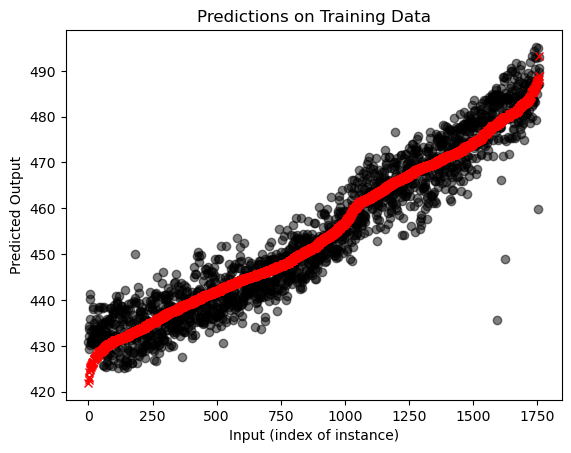

In [8]:
# Plot predictions on Training data 
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_training[0:m_training])), key=lambda k: prediction_training[0:m_training][k])
plt.plot(Y_training[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_training[sorting_permutation], 'rx')

plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Training Data')
plt.show()

### (2) output predictions on validation  data

Plot predictions on validation data.

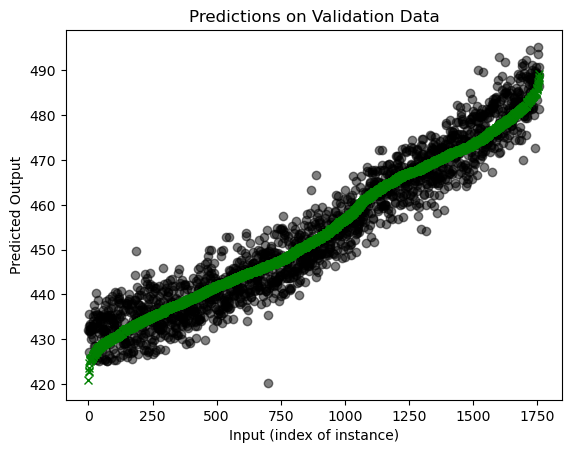

In [9]:
# Plot predictions on validation data 
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_validation[0:m_validation])), key=lambda k: prediction_validation[0:m_validation][k])
plt.plot(Y_validation[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_validation[sorting_permutation], 'gx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Validation Data')
plt.show()

Also gonna be adding the plotting for predictions on test data in order to have a visual confirmation of the 93.05% of accuracy indicated by the R_measure_test value.

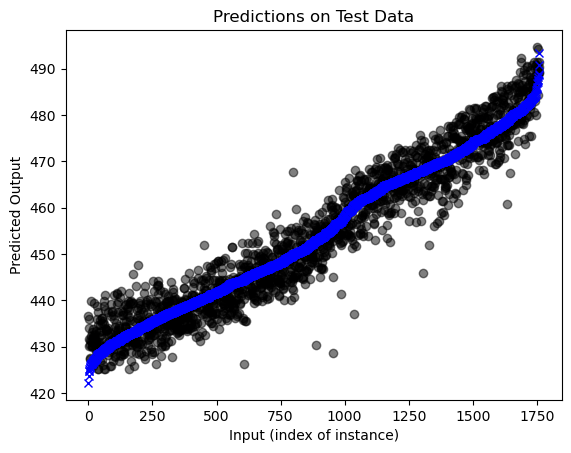

In [10]:
# Plot predictions on test data 
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_test[0:m_test])), key=lambda k: prediction_test[0:m_test][k])
plt.plot(Y_test[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_test[sorting_permutation], 'bx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Test Data')
plt.show()

# Removing some features

Perform same as above removing 1 feature that you think may not be as important as the other ones for prediction; recall that, since the data has been normalized, may be done by looking at the weights of each feature in the learned model.

**QUESTION**: Could we remove one feature and still have a decently performing model?

**ANSWER**: looking at the LR Coefficients it is clear that 3 out of the 4 features have a negative coefficient, while only one feature has a positive one. Given that all three negative coefficients are quite similar we can assume that getting rid of any one of them wouldn't probably change that much the result, whereas removing the feature with the only positive coefficient would probably lead to quite some variations.

I chose to perform an examination in both cases by taking the same dataset and removing, respectively:

###### - the feature with the biggest coefficient amongst the negative ones;
###### - the ONLY feature with the positive coefficient;
######   
The results are shown below.

### Plot prediction on validation data for the reduced model - Least Impacting Coefficient Feature Removed

Since, like I said above, three features are quite similar in terms of LR coefficients, there really isn't a specific feature we can remove that can maintain the quality of the model. Any of the three AV, V or RH components can be getting ridden of without any catastrophic consequences. In the following cells I chose to remove RH as the final results for validation and test analysis lead to slightly better results.

In [11]:
df.drop(["RH"], axis = 1, inplace = True)

In [12]:
data = df.values
print(data)

[[  12.88   43.8  1023.19  468.19]
 [   9.51   38.38 1022.77  474.93]
 [  30.67   72.86 1004.25  432.76]
 ...
 [  23.82   60.32 1016.61  445.  ]
 [  31.12   69.13 1009.61  429.41]
 [  15.56   41.1  1004.65  467.32]]


In [13]:
# reduced design matrix

#selected_features = ['AT', 'V', 'AP']
X_training_reduced = data[0:size_chunk, 0:3]
X_validation_reduced = data[size_chunk:2*size_chunk, 0:3]
X_test_reduced = data[2*size_chunk:, 0:3]

#adding the 1 in front of every element of the training set with the function hstack doesn't change the result.

# Compute the coefficients for linear regression (LR) using linalg.lstsq
w_np_reduced, RSS_tr_np_reduced, rank_X_tr_reduced, sv_X_tr_reduced = np.linalg.lstsq(X_training_reduced, Y_training, None)


# Compute predictions
prediction_training_reduced = np.dot(X_training_reduced, w_np_reduced)
prediction_validation_reduced = np.dot(X_validation_reduced, w_np_reduced)
prediction_test_reduced = np.dot(X_test_reduced, w_np_reduced)

#Compute Training Error
RSS_training_reduced = np.sum((Y_training-prediction_training_reduced)**2)

'''
Updating the values for m_training, m_validation and m_test is utterly
useless as the coordinate .shape[0] will always give the same amount of
rows. We removed a feature, so a column, meaning that the number of rows
will remain unchanged and so the results will not vary according to that.

m_training = X_training_reduced.shape[0]
m_validation = X_validation_reduced.shape[0]
m_test = X_test_reduced.shape[0]
'''

print("RSS on training data of reduced model:"+str(RSS_training_reduced))
print("Loss estimated from training data of reduced model:"+str(RSS_training_reduced/m_training))


# Compute Validation Error
RSS_validation_reduced = np.sum((Y_validation-prediction_validation_reduced)**2)

print("RSS on validation data of reduced model:"+str(RSS_validation_reduced))
print("Loss estimated from validation data of reduced model:"+str(RSS_validation_reduced/m_validation))

# Compute Test Error
RSS_test_reduced = np.sum((Y_test-prediction_test_reduced)**2)

print("RSS on test data of reduced model:"+str(RSS_test_reduced))
print("Loss estimated from test data of reduced model:"+str(RSS_test_reduced/m_test))


#another measure of how good our linear fit is given by the following (that is 1 - R^2)
# Compute Training, Validation, and Test Error as 1-R^2
R_measure_training = 1 - np.linalg.norm(Y_training-prediction_training_reduced)**2/np.linalg.norm(Y_training-Y_training.mean())**2
print("Measure on training data of reduced model:"+str(R_measure_training))
R_measure_validation = 1 - np.linalg.norm(Y_validation-prediction_validation_reduced)**2/np.linalg.norm(Y_validation-Y_validation.mean())**2
print("Measure on validation data of reduced model:"+str(R_measure_validation))
R_measure_test = 1 - np.linalg.norm(Y_test-prediction_test_reduced)**2/np.linalg.norm(Y_test-Y_test.mean())**2
print("Measure on test data of reduced model:"+str(R_measure_test))

RSS on training data of reduced model:49199.17841198627
Loss estimated from training data of reduced model:27.954078643174018
RSS on validation data of reduced model:47270.44257012385
Loss estimated from validation data of reduced model:26.858206005752187
RSS on test data of reduced model:45645.42567562919
Loss estimated from test data of reduced model:25.920173580709363
Measure on training data of reduced model:0.9068019171444063
Measure on validation data of reduced model:0.908016175219074
Measure on test data of reduced model:0.908537549994423


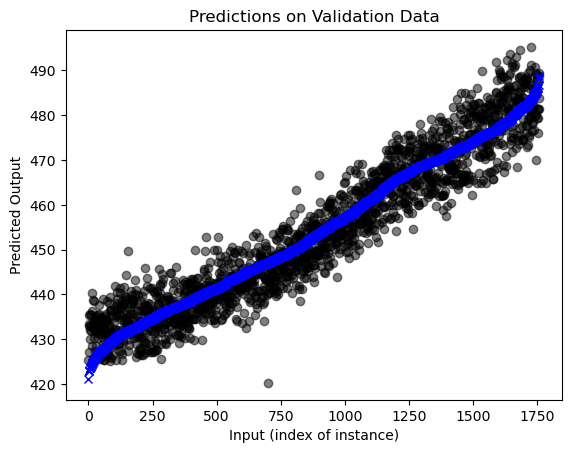

In [14]:
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_validation_reduced[0:m_validation])), key=lambda k: prediction_validation_reduced[0:m_validation][k])
plt.plot(Y_validation[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_validation_reduced[sorting_permutation], 'bx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Validation Data')
plt.show()

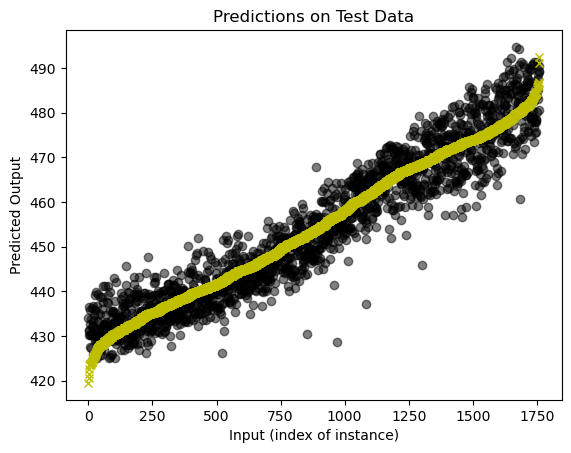

In [15]:
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_test_reduced[0:m_test])), key=lambda k: prediction_test_reduced[0:m_test][k])
plt.plot(Y_test[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_test_reduced[sorting_permutation], 'yx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Test Data')
plt.show()

### Plot prediction on validation data for the reduced model - Wrong Feature Removed

What would happen if we were instead to remove the only feature with a positive LR coefficient? We can assume the model would no longer correctly work, and this can be seen from the plots (and the results for validation & test) in the cells below.

In [16]:
df_1.drop(["AP"], axis = 1, inplace = True)

In [17]:
data = df_1.values
np.random.shuffle(data)

In [18]:
# reduced design matrix

#selected_features = ['AT', 'V', 'AP']
X_training_reduced = data[0:size_chunk, 0:3]
X_validation_reduced = data[size_chunk:2*size_chunk, 0:3]
X_test_reduced = data[2*size_chunk:, 0:3]

# Compute the coefficients for linear regression (LR) using linalg.lstsq
w_np_reduced, RSS_tr_np_reduced, rank_X_tr_reduced, sv_X_tr_reduced = np.linalg.lstsq(X_training_reduced, Y_training, None)


# Compute predictions
prediction_training_reduced = np.dot(X_training_reduced, w_np_reduced)
prediction_validation_reduced = np.dot(X_validation_reduced, w_np_reduced)
prediction_test_reduced = np.dot(X_test_reduced, w_np_reduced)

#Compute Training Error
RSS_training_reduced = np.sum((Y_training-prediction_training_reduced)**2)

'''
Updating the values for m_training, m_validation and m_test is utterly
useless as the coordinate .shape[0] will always give the same amount of
rows. We removed a feature, so a column, meaning that the number of rows
will remain unchanged and so the results will not vary according to that.

m_training = X_training_reduced.shape[0]
m_validation = X_validation_reduced.shape[0]
m_test = X_test_reduced.shape[0]
'''

print("RSS on training data of reduced model:"+str(RSS_training_reduced))
print("Loss estimated from training data of reduced model:"+str(RSS_training_reduced/m_training))


# Compute Validation Error
RSS_validation_reduced = np.sum((Y_validation-prediction_validation_reduced)**2)

print("RSS on validation data of reduced model:"+str(RSS_validation_reduced))
print("Loss estimated from validation data of reduced model:"+str(RSS_validation_reduced/m_validation))

# Compute Test Error
RSS_test_reduced = np.sum((Y_test-prediction_test_reduced)**2)

print("RSS on test data of reduced model:"+str(RSS_test_reduced))
print("Loss estimated from test data of reduced model:"+str(RSS_test_reduced/m_test))


#another measure of how good our linear fit is given by the following (that is 1 - R^2)
# Compute Training, Validation, and Test Error as 1-R^2
R_measure_training = 1 - np.linalg.norm(Y_training-prediction_training_reduced)**2/np.linalg.norm(Y_training-Y_training.mean())**2
print("Measure on training data of reduced model:"+str(R_measure_training))
R_measure_validation = 1 - np.linalg.norm(Y_validation-prediction_validation_reduced)**2/np.linalg.norm(Y_validation-Y_validation.mean())**2
print("Measure on validation data of reduced model:"+str(R_measure_validation))
R_measure_test = 1 - np.linalg.norm(Y_test-prediction_test_reduced)**2/np.linalg.norm(Y_test-Y_test.mean())**2
print("Measure on test data of reduced model:"+str(R_measure_test))

RSS on training data of reduced model:5985400.332538718
Loss estimated from training data of reduced model:3400.7956434879084
RSS on validation data of reduced model:5783709.000937149
Loss estimated from validation data of reduced model:3286.1982959870165
RSS on test data of reduced model:5582630.28087926
Loss estimated from test data of reduced model:3170.1478028843044
Measure on training data of reduced model:-10.338153483878898
Measure on validation data of reduced model:-10.254552451817116
Measure on test data of reduced model:-10.186247809211629


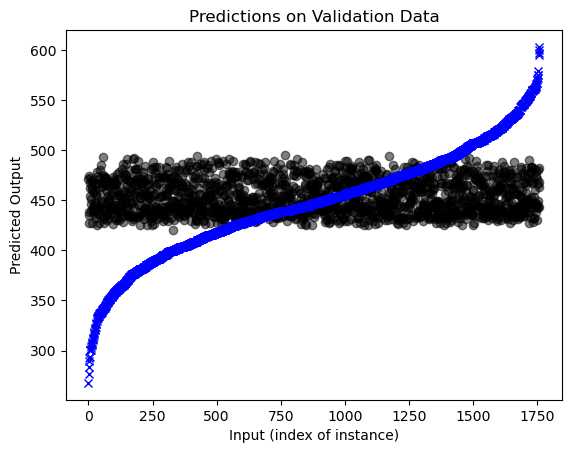

In [19]:
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_validation_reduced[0:m_validation])), key=lambda k: prediction_validation_reduced[0:m_validation][k])
plt.plot(Y_validation[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_validation_reduced[sorting_permutation], 'bx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Validation Data')
plt.show()

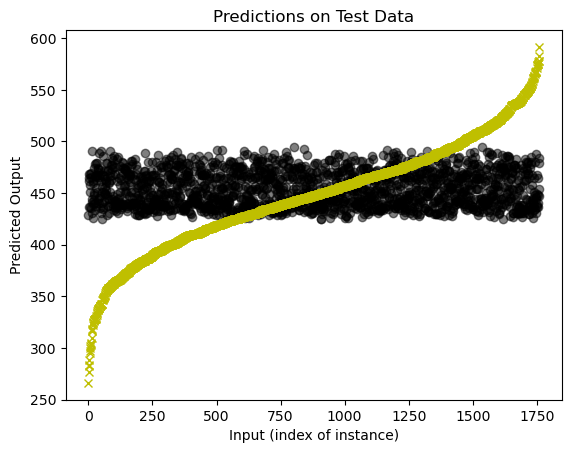

In [20]:
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_test_reduced[0:m_test])), key=lambda k: prediction_test_reduced[0:m_test][k])
plt.plot(Y_test[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_test_reduced[sorting_permutation], 'yx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Test Data')
plt.show()

#### As we can see, there is a huge discrepancy between our model and the dataset, hence the original hypothesis was correct 

# MODEL SELECTION 

The differences between the full model and the reduced model are very much depending from the specific feature that gets removed: in one specific case (AP), removing such feature gives us a model that is completely off when it comes to performing the regression task. This is because the Ambient Pressure indicator is evidently a fundamental feature when it comes to the computation of electrical consumption.

On the other hand, getting rid of any other feature leads to a Linear Regression model that can still operate with tremendous accuracy in both the Validation and Test sets. This means evidently that singularly taken, each feature can be seen as a combination of the remaining ones, so it doesn't really add any kind of information that might be retrieved elsewhere. For this reason, removing the Relative Humidity for example allows us to still have a properly functioning LR model that hasn't lost in accuracy.

## Ordinary Least-Squares using scikit-learn

A fast way to compute the LS estimate is through sklearn.linear_model

In [21]:
# Remove the ''ones'' column in the features matrix (sklearn inserts it automatically)
X_training = X_training[:,1:]
X_test = X_test[:,1:]

In [22]:
from sklearn import linear_model

lin_reg = linear_model.LinearRegression()  # build the object LinearRegression
lin_reg.fit(X_training, Y_training)  # estimate the LS coefficients
print("Intercept:", lin_reg.intercept_)
print("Least-Squares Coefficients:", lin_reg.coef_)
prediction_training = lin_reg.predict(X_training)  # predict output values on training set
prediction_test = lin_reg.predict(X_test)  # predict output values on test set
print("Measure on training data:", lin_reg.score(X_training, Y_training))
print("Measure on test data:", lin_reg.score(X_test, Y_test))

Intercept: [454.42025568]
Least-Squares Coefficients: [[-14.84774016  -3.1659385    0.33219325  -2.42541648]]
Measure on training data: 0.9278716408219753
Measure on test data: 0.928087684705307


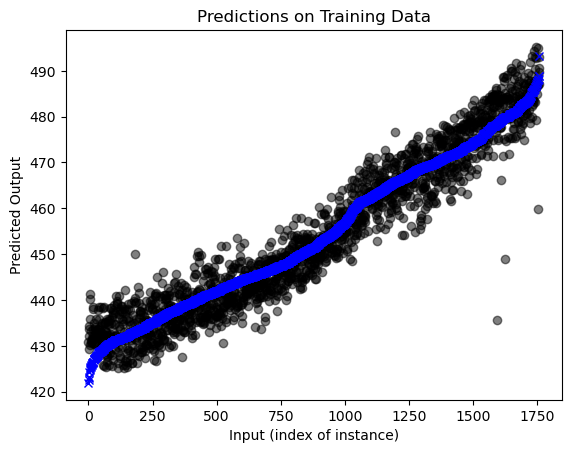

In [23]:
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_training[0:m_training])), key=lambda k: prediction_training[0:m_training][k])
plt.plot(Y_training[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_training[sorting_permutation], 'bx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Training Data')
plt.show()

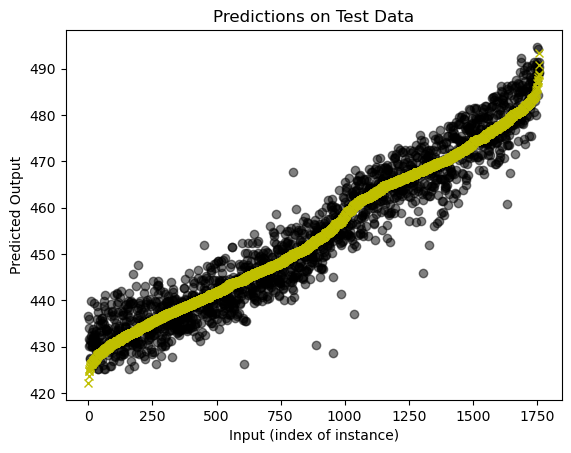

In [24]:
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_test[0:m_test])), key=lambda k: prediction_test[0:m_test][k])
plt.plot(Y_test[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_test[sorting_permutation], 'yx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Test Data')
plt.show()